# Predicting Legendary Pokemon

The goal of our research was to find a model to predict a Pokemon's
legendary status based off typing and battle stat attributes. We will
use the Random Forest classifier. This algorithm is a form of a decision tree
that builds out many individual, uncorrelated trees from the random subsets of the data 
provided and uses a concensus to make decisions more accurately than through strictly 
one decision tree. We will also use SMOTE to generate sythetic data inputs to expand our 
dataset for better accuracy.

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd

### Data Preparation

In [214]:
# Bringing in data through CSV.

# The data chosen contains information about type, battle stats, generation, and legendary status for
# the first six generations of Pokemon.

# We first display the dataset so we have a sense of what we're working with.

poke_csv="Resources/clean_data.csv"
poke_df= pd.read_csv(poke_csv)
poke_df

,#,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


<AxesSubplot:>

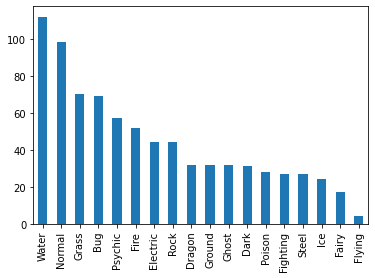

In [215]:
# Visualizing the type distribution throughout the data set.

poke_df["Type1"].value_counts().plot.bar()

<AxesSubplot:>

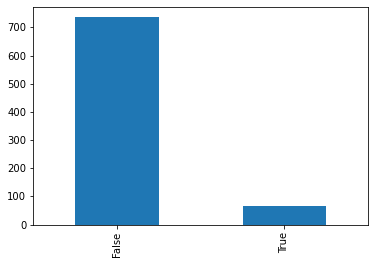

In [216]:
# Visualizing the proportion of legendary to non-legendary Pokemon in the data set.
# As we'll later show, there are 735 non-legendary and 65 legendary Pokemon.

poke_df["Legendary"].value_counts().plot.bar()

In [217]:
# Gather list of unique pokemon types for reference.

type1_list = poke_df["Type1"].unique()
type1_list

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [218]:
# Get a count on the number of unique types for reference.

len(type1_list)

18

### Data Preprocessing 

In [219]:
# Instead of manually recoding the types as shown above,
# we use LabelEncoder. 

# 'fit_transform' will take the type classes and assign them numeric values
# based off the number of classes. We originally split the two actions, but reduced
# the amount of code by using 'fit_transform'.

from sklearn.preprocessing import LabelEncoder

# Label-encoding data set

label_encoder = LabelEncoder()
encoded_type1 = label_encoder.fit_transform(poke_df["Type1"])
encoded_type1

array([ 9,  9,  9,  9,  6,  6,  6,  6,  6, 17, 17, 17, 17,  0,  0,  0,  0,
        0,  0,  0, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,  3,  3, 10, 10,
       13, 13, 13, 13, 13, 13,  4,  4,  6,  6, 12, 12, 13, 13,  9,  9,  9,
        0,  0,  0,  0, 10, 10, 12, 12, 17, 17,  5,  5,  6,  6, 17, 17, 17,
       14, 14, 14, 14,  5,  5,  5,  9,  9,  9, 17, 17, 15, 15, 15,  6,  6,
       17, 17, 17,  3,  3, 12, 12, 12, 17, 17, 13, 13, 17, 17,  8,  8,  8,
        8, 15, 14, 14, 17, 17,  3,  3,  9,  9, 10, 10,  5,  5, 12, 13, 13,
       10, 10, 12,  9, 12, 12, 17, 17, 17, 17, 17, 17, 14,  0, 11,  3,  6,
        0,  0, 12, 17, 17, 17, 17, 12, 12, 17,  3,  6, 12, 15, 15, 15, 15,
       15, 15, 12, 11,  3,  6,  2,  2,  2, 14, 14, 14, 14,  9,  9,  9,  6,
        6,  6, 17, 17, 17, 12, 12, 12, 12,  0,  0,  0,  0, 13, 17, 17,  3,
        4, 12,  4,  4, 14, 14,  3,  3,  3,  3,  9, 17, 17, 15, 17,  9,  9,
        9, 12,  9,  9,  0, 17, 17, 14,  1,  1, 17,  8, 14, 14, 12,  0,  0,
       12, 10, 16, 16,  4

In [220]:
# Get the list and order of pokemon types used by LabelEncoder.

list(label_encoder.classes_)

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [221]:
from keras.utils import to_categorical

# One-hot encoding
# The tool 'to_categorical' will encode class vectors to binary.
# We are doing this because it is the proper format for the Random
# Forest classifier we plan on using.

one_hot_type1 = to_categorical(encoded_type1)
one_hot_type1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [222]:
# Create df that includes one hot encoding
hot_df = pd.DataFrame(one_hot_type1)
hot_df

# Merge the encoding with the Pokemon dataframe
merged_df = pd.merge(poke_df,hot_df, how='outer', left_index=True, right_index=True)
merged_df

# Rename the columns based the LabelEncoder classes found above
final_df = merged_df.rename(columns = {0: "Bug", 
                                       1: "Dark",
                                       2: "Dragon", 
                                       3: "Electric",
                                       4:"Fairy",
                                       5:"Fighting",
                                       6: "Fire",
                                       7: "Flying",
                                       8: "Ghost", 
                                       9: "Grass",
                                       10: "Ground",
                                       11: "Ice",
                                       12: "Normal",
                                       13: "Poison",
                                       14: "Psychic",
                                       15: "Rock",
                                       16: "Steel",
                                       17:"Water"})
final_df.head(10)

,#,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Data Normalization

In [223]:
# We used normalization in this notebook and tested without normalization in another notebook.
# With the Normalizer tool, and specifically the 'transform' function,
# the values for Total, HP, Attack, Defense, SpAtk, SpDef, and Speed will be
# normalized individually to unit norm. Without the normalization, the spread of stats points varied wildly
# from just 5pts to over 200pts.


from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(final_df[["Total","HP","Attack","Defense","SpAtk","SpDef", "Speed"]])
final_df[["Total","HP","Attack","Defense","SpAtk","SpDef", "Speed"]] = transformer.transform(final_df[["Total","HP","Attack","Defense","SpAtk","SpDef", "Speed"]])

final_df

,#,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,1,Bulbasaur,Grass,Poison,0.924067,0.130764,0.142388,0.142388,0.188882,0.188882,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Ivysaur,Grass,Poison,0.924672,0.136988,0.141555,0.143838,0.182651,0.182651,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Venusaur,Grass,Poison,0.925136,0.140973,0.144497,0.146260,0.176216,0.176216,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,VenusaurMega Venusaur,Grass,Poison,0.923685,0.118232,0.147790,0.181781,0.180303,0.177348,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Charmander,Fire,NaN,0.923809,0.116597,0.155463,0.128556,0.179380,0.149484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,0.914991,0.076249,0.152499,0.228748,0.152499,0.228748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
796,719,DiancieMega Diancie,Rock,Fairy,0.919145,0.065653,0.210090,0.144437,0.210090,0.144437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
797,720,HoopaHoopa Confined,Psychic,Ghost,0.918846,0.122513,0.168455,0.091885,0.229711,0.199083,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
798,720,HoopaHoopa Unbound,Psychic,Dark,0.916745,0.107852,0.215705,0.080889,0.229186,0.175260,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Train Test Split for Random Forest

In [224]:
# We are using train-test split to determine how stats and typing affect a
# Pokemon's status as legendary.

from sklearn.model_selection import train_test_split
x = final_df
y = final_df['Legendary']
x = x.drop(["Legendary","Name","#","Type1","Type2","Generation"],1)
x

,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Bug,Dark,Dragon,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0.924067,0.130764,0.142388,0.142388,0.188882,0.188882,0.130764,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.924672,0.136988,0.141555,0.143838,0.182651,0.182651,0.136988,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925136,0.140973,0.144497,0.146260,0.176216,0.176216,0.140973,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.923685,0.118232,0.147790,0.181781,0.180303,0.177348,0.118232,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.923809,0.116597,0.155463,0.128556,0.179380,0.149484,0.194329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.914991,0.076249,0.152499,0.228748,0.152499,0.228748,0.076249,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
796,0.919145,0.065653,0.210090,0.144437,0.210090,0.144437,0.144437,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
797,0.918846,0.122513,0.168455,0.091885,0.229711,0.199083,0.107199,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
798,0.916745,0.107852,0.215705,0.080889,0.229186,0.175260,0.107852,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [225]:
# Creating train and test sets

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 47, test_size = 0.20)

## Balancing the Dataset
We use SMOTE (Synthetic Minority Oversampling Technique), which is a python package that works with Scikit-learn to create synthetic class instances based off the minority class (in this case legendary Pokemon). In this case, we will be oversampling to provide more examples to the X_train and y_train dataframes. A sampling_strategy ratio of 1.0 will equally balance the classes.


In [226]:
# Apply SMOTE algorithm using imblearn 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=15, sampling_strategy = 1.0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [227]:
# The whole dataset is now given.

X_train_res.shape

(1182, 25)

In [228]:
# Showing the amount of legendary Pokemon created, or half the dataset.

(y_train_res == True).sum()

591

In [229]:
# Creating Random Forest model. n_estimators is the number of trees
# in the forest. max_depth is the number of nodes on each tree.

from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators=100, max_depth=)

SyntaxError: invalid syntax (<ipython-input-229-791b14f926e0>, line 5)

In [230]:
# Training the Random Forest classifier. 

model.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=18)

In [243]:
y_pred =  model.predict(X_test)
y_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [232]:
# Importing the accuracy metric from sklearn.metrics library

from sklearn.metrics import accuracy_score
print('Accuracy Score for train data: ', accuracy_score(y_true=y_train_res, y_pred=model.predict(X_train_res)))
print('Accuracy Score for test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy Score for train data:  0.9966159052453468
Accuracy Score for test data:  0.93125


In [242]:
# Feature Importance is something we wanted incorporated to highlight how each specific 
# stat or type attribute correlated towards a Pokemon being classified as legendary.
# They look at model success when considering each attribute. The higher the score,
# the more important that attribute is towards classifying legendaries.

importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances

,Importance
Feature,
SpAtk,0.135
Speed,0.128
Attack,0.105
Psychic,0.092
Total,0.091
HP,0.083
SpDef,0.072
Defense,0.067
Dragon,0.045


<AxesSubplot:xlabel='Feature'>

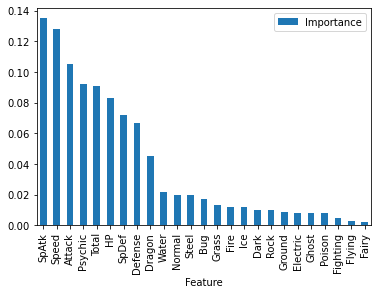

In [241]:
importances.plot.bar()